In [ ]:
# import pandas as pd
# df_player = pd.read_csv("player.csv")
# df_player.drop(columns = ['Unnamed: 0', 'Season', 'pos'], inplace=True)
# df_player.head()

In [ ]:
# # Clean salary columns and remove na
# import numpy as np
# df_player = df_player[df_player['salary'].notna()]
# df_player['salary'] = df_player['salary'].str.replace(',', '')
# df_player['salary'] = df_player['salary'].str.replace('$', '')
# df_player['salary'] = df_player['salary'].apply(lambda x: np.nan if 'Minimum' in x or 'TW' in x else x)
# df_player = df_player[df_player['salary'].notna()]
# df_player = df_player.astype({"salary": int})


In [ ]:
# df_player = df_player.sort_values('Team_url',ascending=True).reset_index(drop=True)
# df_player.tail()

In [ ]:
# df_player.drop_duplicates(subset=['player_url', 'season'], inplace=True, keep='last')
# df_player = df_player.reset_index(drop=True)
# df_player.tail()

In [ ]:
# # Remove seasons not in range between 2009-01 to 2019-20)
# print('Before remove seasons row count: %d'%df_player.shape[0])
# df_player['season_year'] = df_player['season'].apply(lambda x: x.split('-')[0])
# df_player = df_player.astype({"season_year": int})
# df_player = df_player[(df_player['season_year'] <= 2019) & (df_player['season_year'] >= 2009) ]
# print('Before remove seasons row count: %d'%df_player.shape[0])
# df_player.tail()

In [ ]:
# df_player.to_csv('new_player.csv', index=False)
# df_player.info(null_counts=True)

# Q3.1 Clustering. Which players are similar? (10 points)

In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
pd.options.display.max_columns = None
df = pd.read_csv('new_player.csv')
df = df.dropna(how='any')
df.replace(to_replace=['None'], value=np.nan, inplace=True)
# Add Total minutes player col MT
df['MT'] = df['G']*df['MP']
# Convert height to cm
df['ht_cm'] = df['ht'].apply(lambda x: (12*int(x.split('-')[0]) + int(x.split('-')[1]))*2.54)
# Cat colleague educated as CE
df['CE']= df['college'].notna()
df["CE"] = df["CE"].astype(int)
# Drop unrelated columns
df.drop(columns = ['Team_url', 'Team', 'Lg', 'CE', 'ht_cm', 'Pos', 'dob', 'lg', 'draft_team', 'ht','from', 'to', 'season', 'recruiting_rank','college','team', 'url', 'player_url'], inplace=True)
df["active"] = df["active"].astype(int)

In [5]:
# # Use dummy encoding to process teams
# df['Pos']= df['Pos'].apply(lambda x: x.split(',')) # process data for players with two positions.
# df = df.explode('Pos')
# df = pd.get_dummies(df, columns=['Pos'])
# df = df.groupby([x for x in df.columns.values if 'Pos' not in x])[[x for x in df.columns.values if 'Pos' in x]].sum().reset_index()
# df.head()

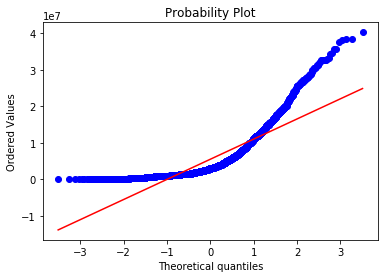

In [6]:
import numpy as np 
import pylab 
import scipy.stats as stats
import math
stats.probplot(df['salary'], dist="norm", plot=pylab)
pylab.show()

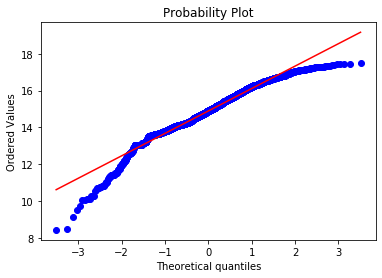

In [7]:
df['salary_log'] = df['salary'].apply(lambda x: math.log(x))
stats.probplot(df['salary_log'], dist="norm", plot=pylab)
pylab.show()

In [8]:
df = df[df['season_year']==2019]
df_target = df[['salary_log','name', 'salary']]
df_features = df.drop(columns=['salary_log', 'name', 'salary', 'season_year'])

In [9]:
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
    regressor_OLS.summary()
    return x, columns

SL = 0.05
selected_columns = df_features.columns.values
print(len(selected_columns))
data_modeled, selected_columns = backwardElimination(df_features.values, 
                                                    df_target['salary_log'].values, SL, selected_columns)
print(len(selected_columns))
print(selected_columns)

30
14
['Age' 'G' 'MP' 'FGA' '3P' '3P%' '2P' 'eFG%' 'FT%' 'STL' 'PF' 'wt'
 'active' 'MT']


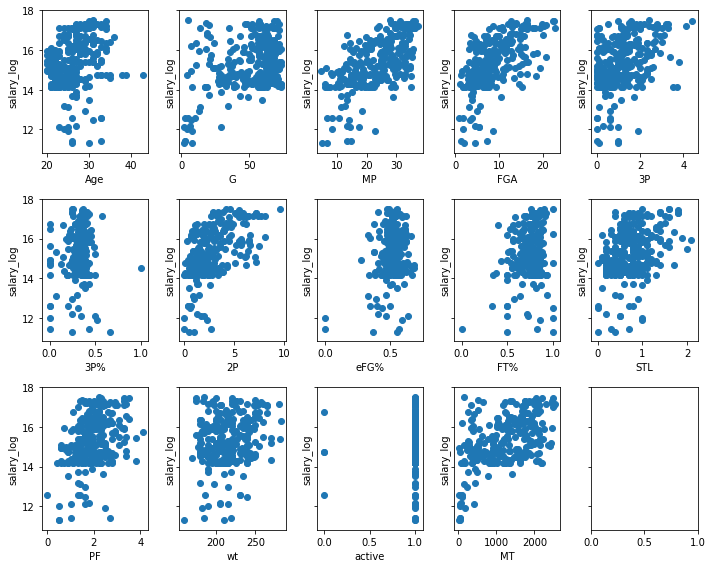

In [10]:
fig, axes = plt.subplots(3, 5, figsize = (10, 8), sharey=True)

for idx in range(0,3):
    for idy in range(0,5):
        if idx*5 + idy >= len(selected_columns): continue
        col = selected_columns[idx*5 + idy]
        axes[idx, idy].scatter(df[col], df['salary_log'], cmap='viridis' )
        axes[idx, idy].set_xlabel(col)
        axes[idx, idy].set_ylabel('salary_log')
plt.tight_layout()
plt.show()

In [11]:
# df_features = pd.DataFrame(data = data_modeled, columns = selected_columns)
print(selected_columns)
# selected_columns
df_features = df[selected_columns]
df_features.head()

['Age' 'G' 'MP' 'FGA' '3P' '3P%' '2P' 'eFG%' 'FT%' 'STL' 'PF' 'wt'
 'active' 'MT']


,Age,G,MP,FGA,3P,3P%,2P,eFG%,FT%,STL,PF,wt,active,MT
142,21,56,31.4,10.9,2.3,0.380,2.2,0.517,0.828,0.9,2.5,190,1,1758.4
143,43,60,14.6,5.1,1.0,0.302,0.8,0.452,0.793,0.4,1.5,220,0,876.0
144,25,14,11.4,3.1,0.1,0.067,0.9,0.330,0.647,0.5,1.4,198,1,159.6
145,22,41,33.2,14.8,1.4,0.401,7.2,0.632,0.800,0.8,3.4,235,1,1361.2
146,31,19,13.2,3.5,0.0,0.000,1.3,0.373,0.857,0.5,1.1,220,0,250.8


#### a. Apply “k-means” algorithm.

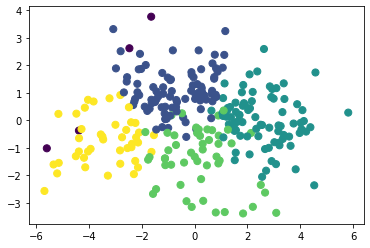

In [12]:
# standard scaling input features
scaler = StandardScaler()
X = scaler.fit_transform(df_features)
kmeanModel = KMeans(n_clusters=5, init='k-means++', n_init=10)
y_kmeans = kmeanModel.fit_predict(X)

# plot KMEANS result using PCA
PCA_model= PCA(n_components=2)
pca_result = PCA_model.fit_transform(X)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_kmeans, s=50, cmap='viridis')


## b.With k-mean clustering, what attributes about the players do you use, as to justify the players’ salaries?
### Answer: Based on the correlation between each features and salary_log, based on criteria with p_value at 0.05. Below is the features we have selected for KMeans modelling. 

In [13]:
features_selected = df_features.columns.values
print(features_selected)

['Age' 'G' 'MP' 'FGA' '3P' '3P%' '2P' 'eFG%' 'FT%' 'STL' 'PF' 'wt'
 'active' 'MT']


## c. How many clusters k do you choose and why?
### Based on the elbow plot as below, k=6 is at the 'elbow' of the within-cluster sum of squared distance plot.

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

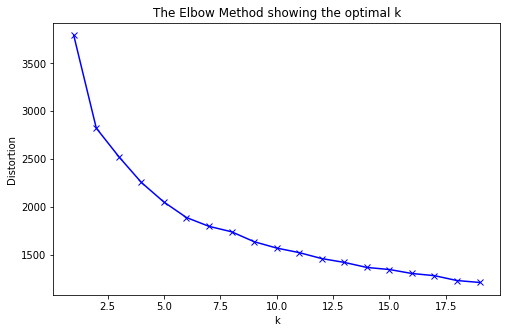

In [14]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', n_init=10)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

### d. Do you get different results with different (random) initialization of centers? Can you find parameters, i.e. k and attributes, that yield “stable” clustering?
#### Answer: Based on the plot below, with different init centroid, the clustering results are different from each other.

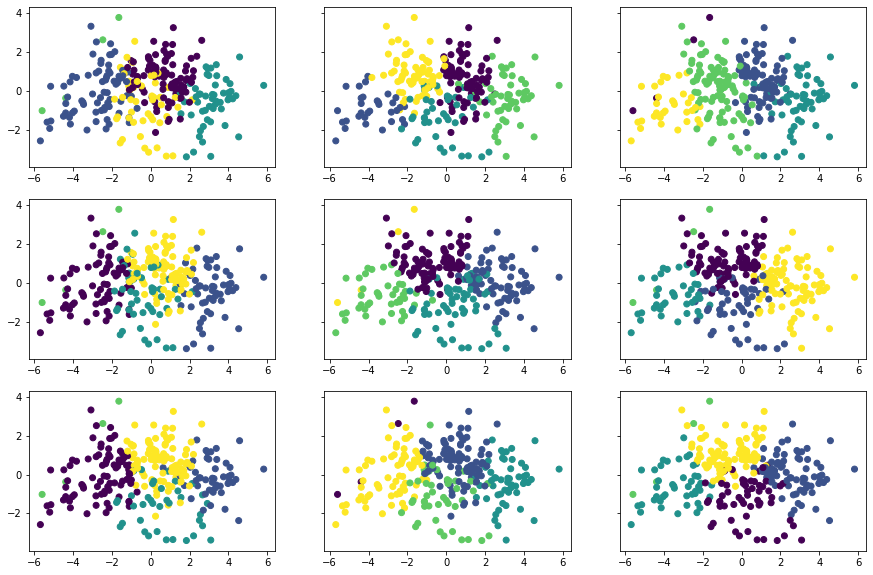

<Figure size 432x288 with 0 Axes>

In [15]:
PCA_model= PCA(n_components=2)
pca_result = PCA_model.fit_transform(X)
fig, axes = plt.subplots(3, 3, figsize = (15, 10), sharey=True)

seed_list = [0, 24, 48, 72, 96, 10, 100, 300, 500]
for idx in range(0,3):
    for idy in range(0,3):
        seed = seed_list[idx*3 + idy]
        # standard scaling input features
        scaler = StandardScaler()
        X = scaler.fit_transform(df_features)
        kmeanModel = KMeans(n_clusters=5, init='random', n_init=10, random_state=seed)
        y_kmeans = kmeanModel.fit_predict(X)
        # plot KMEANS result using PCA
        axes[idx, idy].scatter(pca_result[:, 0], pca_result[:, 1], c=y_kmeans, cmap='viridis')
    
plt.show()
plt.clf()

#### e. How do you interpret the clusters to your boss? What do each cluster mean (in terms of the attributes)?

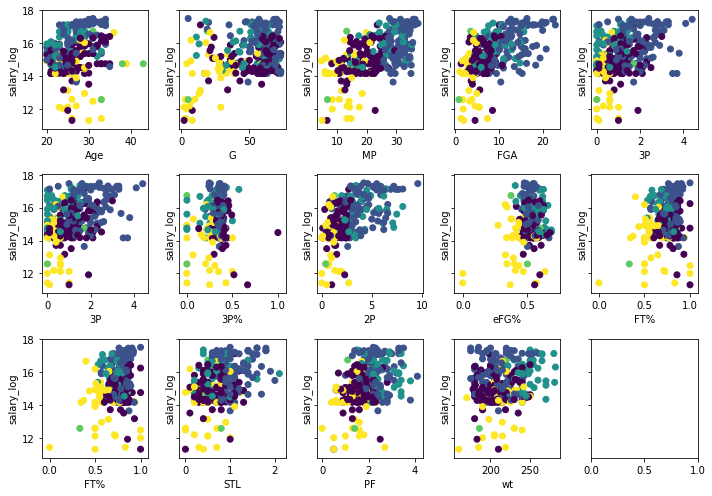

In [16]:
# standard scaling input features
scaler = StandardScaler()
X = scaler.fit_transform(df_features)
kmeanModel = KMeans(n_clusters=5, init='k-means++', n_init=10)
y_kmeans = kmeanModel.fit_predict(X)

fig, axes = plt.subplots(3, 5, figsize = (10, 7), sharey=True)

for idx in range(0,3):
    for idy in range(0,5):
        if idx*5 + idy >= len(features_selected): continue
        col = features_selected[idx*4 + idy]
        axes[idx, idy].scatter(df[col], df['salary_log'], c=y_kmeans, cmap='viridis' )
        axes[idx, idy].set_xlabel(col)
        axes[idx, idy].set_ylabel('salary_log')
plt.tight_layout()
plt.show()

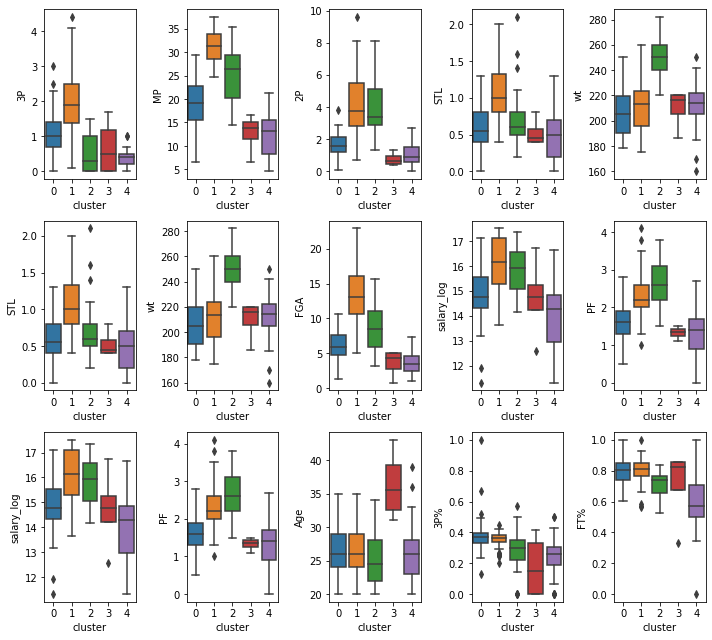

In [35]:
import seaborn as sns
df['cluster'] = y_kmeans
fig, axes = plt.subplots(3, 5, figsize = (10, 9), sharey=False)
features_selected_temp = list(set(features_selected.tolist()+ ['salary_log']))

for idx in range(0,3):
    for idy in range(0,5):
        col = features_selected_temp[idx*3 + idy]
        sns.boxplot(y = col, x = 'cluster', data = df, ax=axes[idx, idy]).set(ylabel=col)
plt.tight_layout()
plt.show()